In [1]:
#hide
!pip install -Uqq fastbook

     |████████████████████████████████| 719 kB 5.0 MB/s 
     |████████████████████████████████| 432 kB 60.0 MB/s 
     |████████████████████████████████| 4.9 MB 52.0 MB/s 
     |████████████████████████████████| 1.3 MB 47.9 MB/s 
     |████████████████████████████████| 212 kB 73.7 MB/s 
     |████████████████████████████████| 163 kB 68.7 MB/s 
     |████████████████████████████████| 115 kB 48.8 MB/s 
     |████████████████████████████████| 127 kB 75.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.1 MB/s 


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier
- 숫자 분류기의 학습 내부 들여다보기

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3 = Image.open(threes[1])
im3

In [9]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- WARNING: 더 나아가기 전에 컴퓨터에 이 두 숫자를 인식시킬 방법을 잠시 생각해보자. 숫자로 표현된 픽셀값에 어떤 특징이 있을까? 특징은 어떻게 식별할 수 있을까? 잠시 진행을 멈추고, 떠오르는 생각을 정리해보거나 종이에 적어보자.

## First Try: Pixel Similarity
- 첫 번째 시도: 픽셀 유사성(유사도)
    - 첫 번째로 시도할 방법은 이렇다. 숫자 3과 7 각각에 대한 모든 이미지의 평균 픽셀값을 구한다. 두 숫자에 대해 얻은 평균 픽셀값을 각각 '이상적인' 3과 7로 정의해볼 수 있다. 그리고 새로운 이미지가 이상적인 두 이미지(3과 7) 중 어느 쪽에 가까운지 계산하여 분류할 수 있다. 최선의 방법은 아니지만 없는 것보다는 나은 방법이므로, 이를 `초기 기준선`으로 설정할 수 있다.
        - 하지만 이 방법은 가지고 있는 훈련 데이터에 많이 의존하는 문제가 있다.

- `NOTE: 기준선(Baseline)` - 신뢰할 수 있는 간단한 모델은 적정 수준으로 잘 작동해야만 한다. 또한 다양한 아이디어를 테스트하고 기준선보다 더 나은지를 확인해보려면 구현과 테스트가 쉬워야만 한다. 적당한 기준선이 없다면 내가 만든 복잡한 모델이 얼마나 더 나은지 알 길이 없다. 직전에 언급했듯이, 구현이 쉬운 간단한 모델을 생각해보는 방법으로 기준선을 만들 수 있다. 또는 자신이 원하는 문제와 유사한 문제를 해결한 다른 사람의 해결책을 찾아서 자신의 데이터셋에 적용해보는 방법도 있다. 사실 두 방법을 모두 시도해보는 편이 이상적이다.

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

- PIL 패키지의 Image 객체가 아니라 텐서 형식으로 담긴 이미지를 출력하려면 fastai가 제공하는 `show_image` 함수를 사용한다.

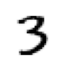

In [13]:
show_image(three_tensors[1]);

- 평균 계산 등 파이토치가 제공하는 일부 연산은 정수 대신 `부동소수형` 데이터만을 지원하여, 작업에 따라 `형 변환`을 해야 한다. 사실 지금 당장 형 변환을 해야 하는 것은 아니지만, 언젠가 해야 하는 작업이므로 구성된 텐서를 미리 부동소수형 데이터로 변환한다. 파이토치에서 형 변환은 매우 간단하다. 단순히 원하는 자료형 이름의 메서드를 호출해주기만 하면 된다.
- 일반적으로 픽셀값을 부동소수로 표현할 때는 그 값을 `0과 1사이로 맞춰준다(min max scaling).` 다음과 같이 255로 나누어 픽셀값이 0~1 범위가 되도록 변환해준다.

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

- 텐서의 속성 중에는 각 축의 길이를 표현하는 `shape`이 가장 중요하다. 앞 코드의 출력 내용을 보면 이미지가 6,131장 있으며, 각각 28x28 픽셀로 구성되었음을 알 수 있다. 하지만 텐서 자체만으로는 각 축이 이미지 개수, 높이 폭을 의미한다는 사실을 알 수 없다. `텐서를 구성하는 각 축의 의미는 순전히 텐서를 만드는 우리가 정한다.` 파이토치 입장에서는 단지 수많은 숫자를 메모리에 저장한다고만 생각할 뿐이다.

In [15]:
stacked_threes[0].shape

torch.Size([28, 28])

- 텐서의 `shape` 속성 길이는 `랭크`라고 표현한다.

In [16]:
len(stacked_threes.shape)

3

- TIP: '차원'이라는 용어는 두 가지 뜻으로 사용되므로 주의해야 한다. 우리는 '3차원 공간'에 살고, 이 공간의 물리적 위치는 `길이가 3인 벡터 v 로 묘사할 수 있다.` 하지만 파이토치에서 해당 벡터의 `ndim` 속성값은 3이 아니라 1이다(v의 '차원 개수'처럼 보이지만). `v는 벡터라서 랭크가 1인 텐서이다.` 즉 해당 축의 길이가 3이어도 단 하나의 축만 존재한다. 다시 말해 `축의 크기`로 차원을 사용하기도 하지만(3차원 공간), `축의 개수 또는 랭크`로 사용할 때도 있다('두 차원'을 가지는 행렬).

- 텐서에 관련된 용어를 외우고, 이해하고, 쓰임새를 연습해보는 일은 정말 중요하다. 랭크는 텐서의 차원 또는 축의 개수를 뜻하며, `shape`는 텐서 각 축의 크기를 표현한다.
- `len()`함수를 사용하는 대신 `ndim` 속성으로 텐서의 랭크를 즉시 확인할 수 있다.

In [17]:
stacked_threes.ndim

3

- 쌓아 올린 랭크3 텐서에서 `0번째 차원의 평균`을 구해서 모든 이미지 텐서의 평균을 얻습니다. 0번째 차원은 이미지를 색인하는 차원(인덱스)이다. 다시 말해 이 계산은 28x28 크기의 이미지에서 각 픽셀 위치에 대한 `모든 이미지의 평균`을 구하고, 평균 픽셀값으로 구성된 `한장의 이미지`를 만든다.

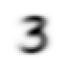

In [18]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

- 인터넷에 올라오는 '한국인의 평균 얼굴 이미지'를 떠올리면 이 작업이 어떤 의미인지 이해가 될 것이다. 현재 주어진 학습 데이터내에서는 숫자 3을 가장 잘 표현하는(일반화된) 이미지이다. 모든 이미지에 대하여 공통적으로 어두운 부분은 매우 어둡고, 일부 이미지에서만 어두운 부분은 희미하고 흐릿하다.
- 숫자 7에 대해서도 같은 작업을 한다.

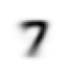

In [19]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

- 이제 임의의 숫자 3 이미지를 고른 다음 '이상적인 숫자들'과의 `거리`를 측정해본다.

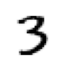

In [20]:
a_3 = stacked_threes[1]
show_image(a_3);

- 이상적인 숫자 3과의 거리를 어떻게 결정할 것인가? `이상적인 숫자와의 픽셀 간 차이`를 단순히 더해서는 문제를 해결할 수 없다. 일부 차이에서는 양수, 다른 차이에서는 음수가 발생한다면 서로를 더했을 때 상쇄된다. 극단적으로는 차이를 더했을 때 0으로만 구성되는, 즉 이상적인 숫자와 차이가 없어 보이게 만드는 결과를 얻을지도 모른다. 그리하여 데이터 과학자는 주로 두 가지 방법으로 이 문제 현상을 방지한다.
    - `차이의 절댓값에 대한 평균`을 구하는(음수를 양수화) 방법. `L1 노름` 또는 `평균절대오차, Mean Absolute Error(MAE)`라고 한다.
    - `차이의 제곱(모든 수를 양수화)에 대한 평균의 제곱근`을 구하는 방법. `L2 노름` 또는 `평균제곱근오차, Root Mean Squared Error(RMSE)`라고 한다.

In [21]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

- 각 방법 모두에서 선택한 '임의의 숫자 3 이미지'는 이상적인 숫자 7보다 이상적인 숫자 3과의 거리가 더 짧다. 즉 간단히 만든 기준선 모델이 예측을 올바르게 수행했다고 볼 수 있다.
- 파이토치는 이 두 방법에 대한 `손실 함수`를 제공한다. 각 손실 함수는 `torch.nn.functional` 에서 찾아볼 수 있다.
    - 파이토치 제작팀은 이 모듈을 `F`라는 이름으로 `import` 하기를 권장하며, `fastai`도 이를 `F`로 `import` 한다.

In [23]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

- `F.mse_loss()`는 `MSE, 평균제곱오차`, `F.l1_loss()`는 `MAE, 평균절대오차` 혹은 `L1 노름`을 의미한다.
- TIP: 직관적으로 `RMSE`는 `MAE(L1 노름)`보다 실수에 더 강한 패널티를 부여한다고 볼 수 있다(반대로 작은 실수에는 더 관대).

### NumPy Arrays and PyTorch Tensors
- 넘파이 배열과 파이토치 텐서
    - 파이썬은 다른 컴퓨터 언어보다 속도가 느리다. 파이썬에서 그나마 빠르다고 할만한 부분은 NumPy, PyTorch와 같은 라이브러리이다. 그런데 사실 이런 라이브러리는 파이썬이 아닌 다른 언어로 작성되었다. 최적화된 컴파일 단계로 만들어진 객체를 파이썬으로 래핑(lapping)한 것이다(넘파이 및 파이토치의 실제 구현체는 C로 작성됨). 실제로 넘파이 배열과 파이토치 텐서는 순수 파이썬 코드보다 수천 배 빠르게 계산한다.
    - 비슷한 두 구조의 차이점
        - 넘파이 배열은 `다차원 테이블`의 형태로 데이터를 담고, 배열 내의 모든 데이터는 같은 자료형을 따라야 한다. 이 제약사항만 맞춰주면 다양한 모습의 배열을 만들 수 있다. 가령 크기가 서로 다른 배열을 포함한 들쭉날쭉한(jagged) 배열을 정의할 수 있다. '다차원 테이블'이란 리스트(1차원), 테이블/행렬(2차원), 중첩 테이블/큐브(3차원) 이상의 모든 형상을 표현할 수 있음을 의미한다. 또한 넘파이는 내부적으로 모두 같은 자료형의 데이터(넘파이 자료구조의 제약사항)를 `C의 자료구조로 압축`하여 메모리에 저장한다. 여기가 바로 넘파이가 빛나는 부분이다. 이렇게 압축된 자료구조에 최적화된 C 코드로 작성된 다양한 연산자 및 메서드를 제공하여 빠른 속도를 보장한다.
        - 파이토치 텐서는 넘파이 배열과 거의 같지만 추가 기능에 따른 제약사항이 있다. `동일 자료형 데이터가 있는 다차원 테이블`이라는 부분은 같지만, 기본적인 수치형 데이터만 사용할 수 있다. 또한 들쭉날쭉한 배열과 같은 구성도 불가능해서, 항상 크기가 일정한 직사각형 모양이어야 한다. 파이토치는 넘파이가 제공하는 대다수의 연산자 및 메서드를 같은 형식으로 지원한다. 또한 파이토치 텐서만의 능력이 더 있다(그래야만 파이토치 텐서를 쓰는 이유가 있지 않겠는가?). 그중 가장 중요한 능력은 파이토치 텐서를 GPU에 적재한다는 것이다. 그러면 넘파이보다 훨씬 더 빠른 GPU에 최적화된 계산을 할 수 있다. 또한 파이토치는 자동으로 미분(다양한 연산 조합에 대한 미분까지도)을 실행하여 미분계수(기울기, 경사도)를 계산할 수 있다.

In [24]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [25]:
arr  # NumPy

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns  # PyTorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [27]:
tns[1]

tensor([4, 5, 6])

In [28]:
tns[:,1]

tensor([2, 5])

In [29]:
tns[1,1:3]

tensor([5, 6])

In [30]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [31]:
tns.type()

'torch.LongTensor'

- 텐서에는 자료형이 있다. 그리고 필요하면 자동으로 자료형을 바꾼다. 다음은 정수에서 부동소수로 자료형이 자동으로 바뀌는 예이다.

In [32]:
tns*1.5, (tns*1.5).type()

(tensor([[1.5000, 3.0000, 4.5000],
         [6.0000, 7.5000, 9.0000]]), 'torch.FloatTensor')

## Computing Metrics Using Broadcasting
- 브로드캐스팅으로 평가지표 계산하기
    - `평가지표`란 데이터셋에 표기된 올바른 레이블(객체 검출분야에서는 이를 `ground truth`라고 표현함)과 모델이 도출한 예측을 비교해서 모델이 얼마나 좋은지를 `사용자`가 평가하는 단일 숫자이다. 예를 들어 앞서 본 평균제곱오차, 평균절대오차, 전체 평균을 구하는 함수를 평가지표로 사용할 수도 있겠으나, 세 지표 모두 사람이 직관적으로 이해하기는 쉽지 않으므로 보통 `정확도(accuracy)`를 분류 모델 평가지표로 사용한다.
    - 우리가 평가지표를 계산하려는 대상은 `검증용 데이터셋(validation set)`이다. 즉 모델이 훈련용 데이터로 학습한 후 검증용 데이터를 이용하여 예측을 수행한 것을 해당 검증용 데이터의 올바른 레이블과 비교하여 평가지표를 계산한다. 그 이유는 의도치 않게 학습용 데이터셋에서만 잘 작동하는 `과적합(overfit)`을 피하기 위함이다. 첫 번째 시도로 만든 픽셀 유사도 모델은 학습이라는 요소가 전혀 없어서 이런 문제가 없었다. 하지만 모델은 대부분 학습으로 구축되기 때문에 관례적으로 검증용 데이터셋을 사용한다. 이 관례를 따르는 두 번째 시도를 준비하는 일환으로 검증용 데이터셋을 사용한다.
    - 검증용 데이터셋을 얻으려면 학습에 사용되는 일부 데이터를 완전히 제거해야 한다. 혹은 검증용 데이터셋을 따로 구축하여 사용해야 한다. 그래야만 모델이 전혀 본 적 없는 데이터를 예측 함으로써 좀 더 객관화된 결과를 얻을 수 있다.

In [33]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

- 위 코드에서 보다시피 크기가 28x28인 1,010장의 숫자 3에 대한 검증용 이미지, 크기가 28x28인 1,010장의 숫자 7에 대한 검증용 이미지를 표현하는 두 텐서를 만들었다.
- 궁극적인 목표는 임의로 입력된 이미지가 3 또는 7인지를 판단하는 함수를 만드는 것이다. 즉 임의의 이미지가 '이상적인 숫자' 두 개 중 어느 쪽에 더 가까운지를 결정하는 역할을 한다. 여기서는 이 함수를 `is_3` 라는 이름으로 정의한다. 그리고 이 함수를 만들려면 두 이미지 사이의 거리를 계산해야 하므로, 우선 거리의 개념부터 정의해야 한다.
- `is_3` 함수가 반환하는 결괏값은 이전에 살펴본 평균절대오차(MAE)와 매우 유사한 형태로 숫자 3과 7을 결정하는 거리를 계산한 결과를 반환한다.

In [34]:
def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))

mnist_distance(a_3, mean3)

tensor(0.1114)

- `a_3`와 `mean3`는 단일 이미지를 표현하는 텐서이다. 각각 임의의 숫자 3, 이상적인 숫자 3을 표현하며, 둘 다 [28, 28] 모양이다. 그리고 계산 결과는 앞서 계산된 두 이미지 사이의 거리와 같음을 볼 수 있다.
- 그런데 전체 이미지에 대한 평가지표를 계산하려면, 검증용 데이터셋 내 `모든 이미지`와 이상적인 숫자 3 이미지의 거리를 계산해야만 한다. 이런 계산은 단순히 생각해봤을 때, 반복문을 통해서 검증용 데이터셋을 담은 [1028, 28, 28] 모양의 텐서 `valid_3_tens`에 반복 접근하여, 한 번에 개별 이미지 텐서 하나씩 접근하여 거리를 계산해야 할 것만 같다. 하지만 이보다 더 나은 방법이 넘파이 배열이나 파이토치의 텐서에는 존재한다. 바로 숫자 3의 검증용 데이터셋을 나타내는 텐서 `valid_3_tens`를 통째로 `mnist_distance` 함수에 넣어주는 것이다.

In [35]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1195, 0.1406, 0.1257,  ..., 0.1160, 0.1358, 0.1436]),
 torch.Size([1010]))

- 모양 불일치 에러가 발생하지 않고 모든 이미지에 대해 측정한 거리를 담는 길이가 1,010인 벡터를 반환한다. 여기서 생각해볼것은 위 결과가 바로 이전에 설명했던대로 검증용 데이터셋의 이미지에 각각 접근하여 이상적인 숫자 3 이미지와의 거리를 각각 계산한 결과를 반환했다는 것이다. 어떻게 이런 일이 일어났을까?
- `mnist_distance` 함수 내부에는 뺄셈하는 부분인 `(a-b)`가 있다. 이 부분이 파이토치로 랭크가 서로 다른 두 텐서 간의 연산을 수행할 때 발생하는 `브로드캐스팅`에 기인한다. 브로드캐스팅은 더 낮은 랭크의 텐서를 더 높은 랭크의 텐서와 같은 크기로 자동 확장한다. 이는 텐서를 사용한 코드를 훨씬 쉽고 간결하게 만들어주는 매우 중요한 기능이다. 물론 속도도 반복문을 사용했을 때보다 더 빠르다.
    - 입력 받은 랭크가 서로 다른 두 텐서를 같은 랭크로 만들어주는 브로드캐스팅이 일어난 후, 파이토치는 랭크가 같은 두 텐서에 평상시와 같은 로직을 적용한다. 즉 두 텐서의 서로 대응되는 요소에 연산을 수행하여 얻는 텐서를 결과로 반환한다. 아래는 이를 보여주는 간단한 예시이다.

In [36]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

- 파이토치는 단일 이미지를 표현하는 랭크2 텐서인 `mean3`에 복사본 이미지가 1,010장 있다고 `취급`하여 검증용 데이터셋 내의 각 이미지와 복사본 이미지에서 뺄셈을 수행한다. 그 결과로 얻은 텐서의 모양은 다음과 같다.
    - 이상적인 숫자 3과 검증용 데이터셋의 모든 숫자3 이미지 간의 차이를 계산한 결과로 얻은 텐서의 모양은 [1028, 28, 28]이다.
- 성능, 표현성 측면에서 모두 뛰어난 브로드캐스팅을 구현할 때 중요한 고려사항이 두 가지 있다.
    - 사실 파이토치는 `mean3`을 1,010번 복사하지 않는다. `그 모양의 텐서인 척`하지만, 실제로 메모리를 추가 할당하지는 않는다.
    - 실제 모든 계산은 C로 수행된다(GPU가 있고 CUDA를 설치했다면, GPU를 활용하는 C 코드가 수행된다). 순수 파이썬보다 수만 배 빠르며, GPU 사용시 수백만 배 빠르게 계산을 수행한다.

In [37]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

```python
def mnist_distance(a, b):
    return (a-b).abs().mean((-1, -2))
```
- 이제 `mnist_distance` 함수에서 `.abs()` 부분을 살펴보면 텐서내 개별 요소(여기서는 이미지의 각 픽셀을 의미)마다 `abs`메서드가 적용되어 새로운 텐서를 반환한다. 즉 `abs`메서드는 `요소별로` 적용된다. 따라서 절댓값으로 바뀐 값(28x28) 1,010개로 구성된 텐서를 얻는다.
- `mnist_distance` 함수는 마지막으로 `.mean(-1, -2)` 를 호출한다. `(-1, -2)` 튜플은 축의 범위를 의미한다. 즉 이미지의 가러와 세로에 대해서만 범위를 지정했으므로, 이 코드는 이미지 텐서의 가로와 세로의 모든 값에 대한 평균을 구하는 작업을 수행한다. 마지막 두 축에서 평균을 구한 결과로 얻는 텐서에는 이미지의 인덱스를 담당한 첫 번째 축만 남게 된다. 최종적으로 얻은 텐서의 크기가 [1010]인 이유이다. 즉 모든 이미지에 대해 각 이미지의 픽셀 강도평균을 구한것이다.
- `mnist_distance` 함수를 '만약 특정 숫자 이미지와 이상적인 숫자 3과의 거리가 이상적인 숫자 7과의 거리보다 짧다면, 그 숫자 이미지를 3이라고 판단하는' 로직에 활용하면 이미지가 숫자 3인지 혹은 7인지를 알아낼 수 있다. 이 함수는 모든 파이토치의 함수와 연산자처럼 자동으로 브로드캐스팅을 수행하고 요소별로 적용될 수 있다.

In [38]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

- 예시를 들어 임의의 숫자3 단일 이미지를 `is_3` 함수에 넣어보자

In [39]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

- `is_3` 함수는 결과로 불리언값을 반환하는데, 이를 `float`메서드로 부동소수화하면 `True`와 `False`에서 각각 `1.0`과 `0.0`을 얻는다.
- 또한 브로드캐스팅 덕분에 검증용 데이터셋의 모든 숫자 3 이미지에서도 적용시켜볼 수 있다.

In [40]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

- 이제 모든 준비가 끝났으니 `is_3` 함수를 이용하여 검증용 데이터셋의 모든 숫자 3과 7에 대한 평균을 계산해서 각각의 이미지가 어떤 숫자인지 판단하고 그에 대한 정확도를 계산할 수 있다.

In [41]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s) / 2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD) - 확률적 경사 하강법

- 아서 사무엘이 묘사한 머신러닝: `"실제 성능적 관점에서 현재 할당된 모든 가중치의 유효성을 자동으로 검증하는 수단이 있으며, 성능을 최대화하는 방향으로 할당된 가중치를 수정해나가는 매커니즘이 존재한다고 가정해봅시다. 그렇다면 전체를 자동화하는 과정을 살세히 이해할 필요 없이, 단지 컴퓨터가 경험으로부터 '학습'하며 프로그래밍되는 것을 지켜보기만 하면 됩니다."`
- 이 부분이 바로 학습을 통해서 모델이 계속 더 나아지는 비결이다. 그런데 앞서 만든 기준점(픽셀 유사도 방식)은 이런 학습의 과정을 전혀 수행하지 않는다. 가중치 할당, 할당된 가중치의 유효성 판단에 기반해 성능을 향상하는 방식을 제공하지 않는다. 즉 파라미터 조정을 사용한 픽셀유사도 방식의 개선이 불가능하다. 딥러닝의 능력을 이용하려면, 사무엘이 묘사한 방식대로 풀고자 하는 문제를 정의해야만 한다.
- 특정 이미지와 '이상적인 이미지' 사이의 유사도를 찾는 대신, 개별 픽셀마다 가중치를 설정하고 숫자를 표현하는 검은색 픽셀의 가중치를 높이는 방법을 생각해보자. 가령 숫자 7 이미지 우측 하단에 위치한 픽셀은 활성화될 가능성이 매우 낮지만, 숫자 3 이미지라면 해당 부분이 높은 확률로 활성화될 것이라고 예측할 수 있다. 따라서 이미지 우측 하단 픽셀들의 가중치는 숫자 7에서는 낮게, 숫자 3에서는 높게 매겨진다. 이 과정은 이미지 픽셀(x)과 각 픽셀에 대한 가중치(w)를 입력받는 함수로 표현할 수 있다.
- 예시로 아래 셀의 코드는 숫자 3이 될 확률을 표현한다.

In [42]:
def pr_three(x, w):
    return (x*w).sum()

- 여기서 이미지를 나타내는 벡터 `x`는 2차원으로 표현된 픽셀의 각 행을 이어붙인 1차원의 긴 배열이라고 가정한다. 그리고 `w`는 가중치 벡터이다. 함수를 정의한 다음에는 가중치를 약간씩 조정하는 방법을 생각해봐야 한다. 그래야 충분할 떄까지 가중치 조정 과정을 여러 번 반복하며 더 나은 가중치를 얻을 수 있다.
- 좀 더 구체적으로 알아본다면 다음과 같다. 이는 위에서 작성한 함수를 머신러닝 분류 모델로 만드는 데 필요한 단계이다. 다시 말해 아직 딥러닝을 사용한 훈련을 하는 것이 아닌 간단한 함수를 통해 '머신러닝 분류 모델'을 만드는 실습을 진행하는 것이다.
    1. 가중치를 `초기화(initialize)`한다.
    2. 현재 가중치로 이미지가 3 또는 7인지를 `예측(predict)`한다.
    3. 예측한 결과로 모델이 얼마나 좋은지 계산한다(정답 레이블과의 `손실` 측정)
    4. 가중치 갱신 정도가 손실에 미치는 영향을 측정하는 `그래디언트(경사도 or 기울기, gradient)`를 계산한다.
    5. 4번 단계에서 계산한 그래디언트로 가중치의 값을 `한 단계(step)` 조정한다.
    6. 2번 단계로 돌아가서 2~5 과정을 `반복(repeat)`한다.
    7. 학습 과정을 `멈춰도 좋다`는 판단이 설 떄까지 계속해서 반복한다.
        - 멈춰도 좋다라는 판단 기준은 `모델 성능이 충분`하다고 판단하거나, 시간상 제약으로 멈춰야 할지도 모른다.
        - 모델 성능이 충분하다는 의미는 `모델의 정확도가 높아지다가 낮아지는 시점(변곡점)`을 말한다.
- 위 7단계는 `모든 딥러닝 모델을 학습시키는 핵심 과정`이며 아래 이미지에서도 묘사되고 있다.

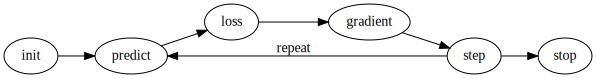

In [43]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

- 위 이미지 상에서 딥러닝의 각 단계를 달성하는 다양한 방법은 딥러닝 실무자들 간의 큰 차이를 만드는 세부 사항이지만, 각 단계의 일반적인 접근법에는 기본 원칙이 존재한다.
    - 초기화
        - 파라미터의 값을 무작위로 초기화한다. 무작위라는 점이 황당하게 들릴지도 모른다. 물론 특정 범주에서 활성화되는 픽셀의 비율에 따른 초기화 등 다른 방법을 생각해볼 수도 있다. 하지만 앞서 배운 가중치를 개선하는 일련의 과정을 거치면 무작위로 초기화된 가중치가 꽤 잘 작동하는 방향으로 갱신된다.
    - 손실
        - 실제 성능 측면에서 현재 할당된 가중치의 유효성 검증에 관해 사무엘이 언급한 내용이다. 여기에는 `모델의 성능이 좋을 때 낮은 값을 반환`하는 함수가 필요하다.(일반적으로 적은 손실은 좋고 큰 손실은 나쁘다고 취급한다.)
    - 가중치 단계 갱신
        - 가중치를 약간 크게 또는 작게 조정해야 하는지를 알아내는 간단한 방법은 일단 시도하는 것이다. 가중치를 약간씩 조정하고 손실의 변화를 관찰하면 된다. 일단 올바른 방향을 찾으면, 잘 작동하는 크기를 찾을 때까지 좀 더 크거나 작은 크기로 바꿔주는 시도를 해볼 수 있다. 하지만 이 과정은 하나씩 건드리며 진행하므로 느릴 수밖에 없다. 그 대신 `미적분학을 사용하여 그래디언트를 계산하면 방향을 즉시 알 수 있으며, 크기를 조금씩 바꾸는 방식을 사용하지 않아도 개략적으로 가중치를 얼마나 갱신해야 하는지를 알 수 있다.` 이는 단순히 성능 최적화 문제로, 수작업으로 천천히 계산하더라도 같은 결과를 얻을 수는 있다.
    - 훈련 종료
        - 모델을 학습할 에포크 횟수를 정하고 적용한다. 숫자 분류 모델 예제에서는 `모델의 정확도가 높아지다가 낮아지는 시점`까지, 또는 시간이 부족한 시점까지 계속해서 학습을 수행한다.

- 위와 같은 단계를 이미지 분류 문제에 적용하기 전에 좀 더 간단한 예를 들어 실습해본다. 일단 매우 간단한 2차 함수를 정의한다. 그리고 이 함수를 손실 함수, `x`를 함수의 가중치 파라미터라고 가정한다.

In [44]:
def f(x): return x**2

- 아래 이미지는 `f(x) = x**2` 함수의 그래프이다.

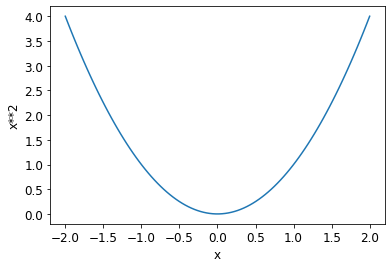

In [45]:
plot_function(f, 'x', 'x**2')

- 앞서 설명한 과정의 시작 부분(파라미터 초기화)처럼 임의의 파라미터값을 선택하고 손실값을 계산한다.

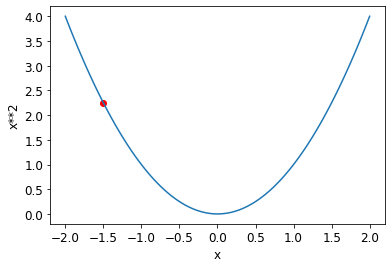

In [46]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

- 그리고 파라미터를 약간씩 크거나 작게 `조정(adjustment)`했을 때 일어나는 일을 살펴보면, 우선 임의로 선택한 특정 지점의 기울기를 구해서 조정의 방향을 정한다.<br>
<br>
- <img src="images/grad_illustration.svg" style="background-color:white">
- 그런 다음 기울기 방향에 따라서 가중치를 약간 바꾼다. 그 후 다시 손실을 계산하고 가중치를 조정하는 과정을 수차례 반복하다 보면, 결국 2차 함수 곡선의 가장 낮은 부분(극소점)에 도달하게 된다.
- 기본 아이디어는 이 방식으로 어떤 함수도 최적화할 수 있다고 지적한 `아이작 뉴턴`의 시대까지 거슬러 올라간다. 함수의 복잡도와는 상관없이, 기본 경사 하강법을 이요한 접근법은 크게 바뀌지 않는다. 다만 가중치 갱신과 관련한 더 좋은 값을 찾아내서 갱신 과정을 빠르게 하는 수준의 변화를 줄 수는 있다.

### Calculating Gradients - 그래디언트(기울기) 계산하기
- 학습의 마법은 그래디언트를 계산할 때 일어난다. 앞서 미적분을 사용하여 성능 최적화를 한다고 언급했다. 파라미터값을 크거나 작게 조정할 때 손실이 커지거나 작아지는지를 더 빠르게 계산할 수 있기 때문이다. 즉 그래디언트는 모델이 더 나아지려면 갱신해야 할 가중치의 정도를 알려준다.
- 미분의 핵심은 이러하다. 앞서 본 2차 함수를 포함한 어떤 함수(단, 함수가 연속이고 미분계수가 존재한다면)도 미분을 계산할 수 있다. 미분 또한 함수이며 값 자체를 계산하지 않고 값의 변화 정도를 계산한다. 가령 값이 3인 지점에서 2차 함수에 대한 미분은 값 3에서 2차 함수가 얼마나 빠르게 변화하는지를 알려준다. 그래디언트가 `y의 변화량/x의 변화량`으로 정의된다는 사실을 상기해보자. 즉 파라미터값의 변화로 함숫값(손실)의 변화를 나눈다. 함수가 변화하는 방식을 알면 무엇을 해야 변화가 작아지는지도 알 수 있다. 이것이 바로 머신러닝의 핵심으로, 함수의 그래디언트를 더 작게 만들도록 파라미터를 조정하는 방법이다.
- 하지만 한 가지 중요한 사실은 함수가 매우 많은 가중치로 구성된다는 점이다. 따라서 미분을 계산할 때도 하나가 아니라 모든 가중치에 대한 그래디언트를 계산해야 한다. 하지만 수학적으로 까다로운 점은 없다. 한 가줃ㅇ치에 대한 미분 계산 시, `다른 가중치들을 상수처럼 취급`하면 그만이다. 그리고 머든 가중치에 대해 이 과정을 반복 수행한다. 그러면 모든 가중치에 대한 그래디언트를 계산할 수 있다. 정리하자면 각각의 가중치에 대한 편미분을 계산하고, 이 과정을 모든 가중치에 적용시킨다.

- 파이토치는 거의 모든 함수에 대한 미분을 자동으로 계산해내는 능력이 있다. 심지어 매우 빠르기까지 하다. 아무리 느려도 사람이 직접 계산할 때보다는 훨씬 빠르다. 아래는 자동 미분에 대한 예시이다.
- 우선 그래디언트를 계산하려는 텐서값 하나를 고른다.

In [47]:
xt = tensor(3.).requires_grad_()
xt.to("cuda")

tensor(3., device='cuda:0', grad_fn=<ToCopyBackward0>)

- `requires_grad_`라는 특별한 메서드가 바로 파이토치에 특정 값의 변수에 대한 그래디언트를 계산해 달라고 하는 마법의 주문이다. 내부적으로는 변수에 일종의 태그를 붙이는 방법이 적용되고, 파이토치는 태그 정보를 활용해 기존의 텐서에 추가 연산이 발생하더라도 모든 연산을 추적하여 그래디언트는 계산하는 방법을 기억한다.

- TIP: 만약 수학이나 물리학을 배웠다면 API 이름에서 혼란을 느낄지도 모른다. 수학이나 물리학에서 말하는 함수의 '그래디언트'는 또 다른 함수(예: 미분)를 의미하므로 그래디언트 관련 API가 새로운 함수를 반환한다고 기대할 수도 있다. 하지만 딥러닝에서는 보통 '그래디언트'가 특정 인잣값(arguments)에 대한 함수의 `미분된 값`을 의미한다.

- 이제 그 값으로 함수를 계산해본다. 파이토치가 계산한 결과를 출력해보면, 단순히 계산된 값뿐만 아니라 그래디언트 함수도 포함한다는 사실을 알 수 있다. 이 함수는 요청 시 경사(slope)를 계산한다.

In [48]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

- 마지막으로 `backward` 메서드를 호출하여 그래디언트를 계산한다.

In [49]:
yt.backward()

- 'backward(역방향)'라는 함수(메서드)의 이름은 각 계층의 미분을 계산하는 과정인 `역전파(backpropagation)`에서 따왔다. 이 과정이 수행되는 방법은 17장에서 심층신경망의 그래디언트는 밑바닥에서부터 계산하는 부분에서 정확히 살펴본다. 역전파틑 네트워크의 `역방향 전파(backward pass)`라고도 불리며, 이에 반대되는 개념으로 활성(activation, 여기서는 모델이 학습과정에서 수행하는 예측값을 의미)을 계산하는 `순방향 전파(forward pass)`가 있다.
- 그래디언트를 계산한 후 텐서의 `grad` 속성(attribute)으로 실제 계산된 그래디언트를 알 수 있다.

In [50]:
xt.grad

tensor(6.)

- TIP: `x.grad` 처럼 뒤에 '()'없이 호출되는 것을 `속성`이라고 하며, `x.backward()` 처럼 뒤에 '()'를 입력한 후에 호출되는 것을 `함수, 메서드`라고 한다.

- 고등학교 미적분에서 배운 규칙을 기억한다면, $x^2$의 미분이 $2x$임을 알 것이다. 따라서, `x=3`의 그래디언트는 `2*3=6`이 되고, 파이토치가 이를 잘 계산했음을 알 수 있다.
- 이번에는 함수에 단일 숫자 대신 벡터를 입력해서 그래디언트를 다시 구해본다.

In [51]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

- 그리고 함수에 `sum` 함수를 추가해서, `벡터(랭크1의 텐서)`가 입력되었을 때 `스칼라값(랭크0의 텐서)`을 출력하도록 만들어준다.

In [52]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

- 이또한 위와 같은 괴정을 거치면 기대한 대로 그래디언트 `2*xt`를 구했다.

In [53]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

- 그래디언트는 함수의 기울기만 알려준다. `파라미터를 얼마나 조정해야 하는지`를 알려주지는 않는다. 하지만 목적지까지 떨어진 정도에 관한 몇 가지 아이디어를 제공한다. 가령 경사가 매우 가파르면 조정을 더 많이 해야 하고, 경사가 덜 가파르면 최적의 값에 가깝다는 사실을 알 수 있다.

In [ ]:
dadsad

### Stepping With a Learning Rate - 학습률을 사용해 단계 밟아 나가기
- 

### An End-to-End SGD Example
- SGD를 활용한 시작부터 끝까지를 보여주는 예제

In [54]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

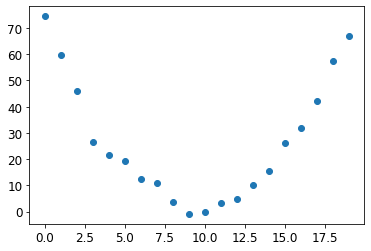

In [55]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed);

In [56]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [57]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters
- 파라미터 초기화

In [58]:
params = torch.randn(3).requires_grad_()

In [59]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [60]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions
- 예측 계산

In [61]:
preds = f(time, params)

In [62]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

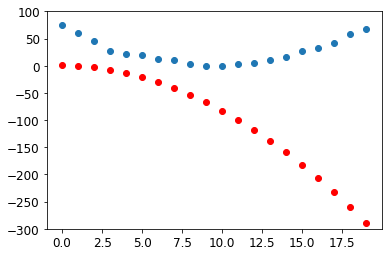

In [63]:
show_preds(preds)

#### Step 3: Calculate the loss
- 손실 계산

In [64]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients
- 그래디언트(기울기) 계산

In [65]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

In [66]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

In [67]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### Step 5: Step the weights.
- 가중치 (한 단계)갱신

In [68]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [69]:
params.data

tensor([-0.2339, -0.7164,  1.3551])

In [70]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

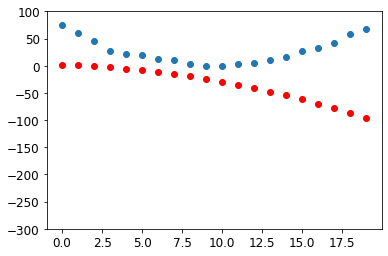

In [71]:
show_preds(preds)

In [72]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process
- 처리 과정 반복

In [73]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [74]:
#hide
params = orig_params.detach().requires_grad_()

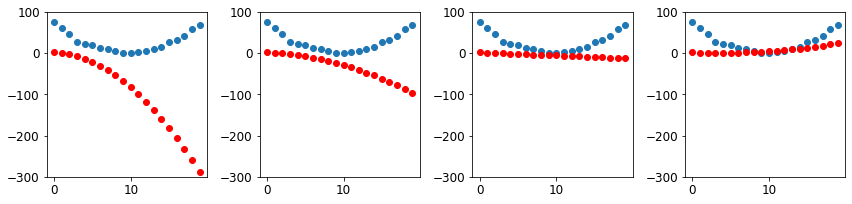

In [75]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop
- 학습 종료
    - 10번의 에포크 후 학습을 종료했다. 임의로 정한 횟수이기에 큰 의미는 없지만, 실전에서는 학습용과 검증용 데이터셋에 대한 손실 및 평가지표를 주시하면서 학습 종료 시점을 결정해야 한다.

### Summarizing Gradient Descent

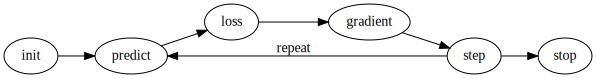

In [76]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

- 경사 하강법 요약
    - 시작 단계에서는 모델의 가중치를 임의의 값으로 설정하거나(`밑바닥부터, from scratch` 학습) 사전에 학습된 모델로부터 설정할 수 있다(`전이 학습, transfer learning`). 첫 번째 방법으로는 입력 데이터에서 원하는 결과를 얻을 수 없다. 두 번째 방법도 완벽하지 않다. 사전에 학습된 모델이 우리가 원하는 특정 문제에서 좋은 성능을 보일 가능성은 작다. 따라서 모델은 `더 나은 가중치를 학습`해야만 한다.
    - `손실 함수(loss func, cost func)`로 모델의 출력값(`활성값, 예측값`)과 타겟값을 비교한다. 그러면 손실 함수는 가중치를 개선해서 가능한 한 낮춰야만 하는 손실값을 반환한다. 이미지 같은 학습용 데이터셋의 데이터 일부(검증용 데이터)를 모델에 주입한다. 그리고 모델이 도출한 예측과 타겟을 손실 함수로 비교한다. 그렇게 얻은 손실값은 모델의 예측이 어긋난 정도를 알려주는 단서이다. 이를 기반으로 가중치를 조금 바꾸면 약간 더 나은 모델을 만들 수 있다.
    - 미적분으로 `그래디언트`를 계산한다.(사실 파이토치는 이를 자동으로 계산하면서 손실을 조금 더 개선하는 가중치 변경 방법을 찾을 수 있다.) 비유적으로 표현해보면, 등산로 입구에 차를 주차하고 등산하다가 산 중턱에서 길을 잃어버린 상황을 상상해보자. 다시 주차장으로 돌아가는 길을 찾으려고 어딘지 모를 임의의 방향으로 방황할지도 모른다. 그런데 이런 길 찾기 방법은 별로 도음이 되지 않는다. 가장 낮은 지점인 등산로 입구에 주차장이 있다는 사실을 알고 있으니 일단 내리막을 찾아 내려가는 편이 '임의의 방향'보다 더 나은 결정이다. 가장 가파른 내리막길 방향으로 계속 내려가야 목적지에 도착할 가능성이 높다. 그리고 경사진 정도(가파른 정도)에 `학습률(learning rate)`이라는 숫자를 곱해서 한 번에 움직여야 하는 양을 알 수 있다. 이 과정을 가장 낮은 등산로 입구 지점에 도달할 떄까지 `반복(iterate)`한다. 그리고 도달하면 그 과정을 `멈춘다.`

## The MNIST Loss Function
- MNIST 손실 함수

In [77]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [78]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [79]:
dset = list(zip(train_x,train_y))
x, y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [80]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [81]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [82]:
weights = init_params((28*28,1))

In [83]:
bias = init_params(1)

-  `NOTE: parameters(파라미터, 매개변수)` - 신경망(모델)을 구성하는 `가중치`와 `편향`을 뜻한다.<br>
`w*x + b` 방정식의 `w`와 `b`가 각각 가중치와 편향이다.

In [84]:
weights.shape, bias  # 가중치, 편향

(torch.Size([784, 1]), tensor([0.6863], requires_grad=True))

In [85]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In [86]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds, preds.shape

(tensor([[20.2336],
         [17.0644],
         [15.2384],
         ...,
         [18.3804],
         [23.8567],
         [28.6816]], grad_fn=<AddBackward0>), torch.Size([12396, 1]))

In [87]:
corrects = (preds>0.0).float() == train_y
corrects, corrects.shape

(tensor([[ True],
         [ True],
         [ True],
         ...,
         [False],
         [False],
         [False]]), torch.Size([12396, 1]))

In [88]:
corrects.float().mean().item()

0.4912068545818329

In [89]:
with torch.no_grad(): weights[0] *= 1.0001

In [90]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

In [91]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [92]:
def mnist_loss(predictions, targets):
    # torch.where(a, b, c) -> [b[i] if a[i] else c[i] for i in range(len(a))]
    # 여기서는 정답이 1일 때 예측이 1과 떨어진 정도를, 정답이 0일 때 예측이 0과 떨어진 정도를 측정하고
    # 이렇게 구한 모든 거리의 평균을 구한다.
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [93]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [94]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [95]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid Function
- 시그모이드 함수
    - (입력값에 상관없이)항상 0~1 사이의 숫자를 출력(반환)
    - 오직 증가만 하는 부드러운 곡선 형태의 함수라서 SGD가 의미 있는 그래디언트를 더 쉽게 찾도록 도와준다.

In [96]:
# sigmoid 함수를 파이썬 코드로 구현한 모습
def sigmoid(x): return 1/(1+torch.exp(-x))

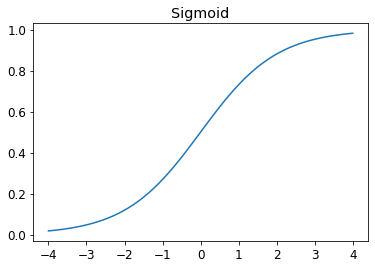

In [97]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [98]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

- 손실 함수가 필요한 이유(왜 손실을 정의해야 할까?)
    - `평가지표`는 사람의 이해를 돕고, `손실`은 자동화된 학습을 이끌어간다는 점이 주된 차이점이다. 따라서 손실은 유의미한 미분이 있는 함수(즉 미분 가능한 함수 -> 연속 함수)여야만 한다. 넓고 평평하거나 급작스러운 변화 구간이 있어선 안되며, 적당히 매끄러운 형태를 띠어야만 한다. 앞서 구상했던 작은 신뢰도 변화에도 반응하는 손실 함수가 이런 특징을 수용한다. 손실 함수의 요구 사항은 사람이 정한 달성목표를 정확히 반영하지는 못하지만, 달성 목표와 그래디언트로 최적화될 수 있는 함수 사이의 절충안으로 볼 수 있다. 손실 함수는 데이터셋의 각 요소에 대해 계산되고, 한 에포크가 끝나는 시점에는 모든 손실값의 평균을 구할 수 있다. 반면 평가지표는 사람이 실제로 관심을 가지는 숫자이다. 매 에포크의 끝에서 모델이 얼마나 학습을 잘했는지를 알려주는 값이다. `손실보다는 평가지표로 모델의 성능을 판단해야 한다는 사실을 알아둬야 한다.`

### SGD and Mini-Batches
- SGD와 미니배치
    - 그래디언트에 기반하여 가중치를 갱신하는 학습의 과정을 `최적화 단계`라고 한다. 최적화 단계를 거치려면 하나 이상의 데이터에 대한 손실을 계산해야만 한다. 그렇다면 얼마나 많은 데이터가 필요할까?
        - 전체 데이터셋에 대한 손실을 계산한다 -> 시간이 너무 오래 걸린다.
        - 단일 데이터셋에 대해서만 손실을 계산 -> 많은(다양한) 정보를 활용할 수 없어서 부정확하고 불안정한 그래디언트가 계산된다. 단일 항목에만 의존하여 모델의 성능을 개선하므로 가중치 갱신에 문제를 겪게 된다.
    - 따라서 절출안이 필요하다. 즉 한 번에 일정 개수의 데이터에 대한 `손실의 평균`을 계산한다. 이런 방식을 `미니배치학습(mini batch training)`이라 하고, 미니배치에 포함된 데이터 개수를 `배치 크기(batch size)`라고 한다. 배치 크기가 클수록 손실 함수로 계산되는 그래디언트가 더 정확하고 안정적으로 추정되지만, 이또한 단일 데이터에 대한 손실 계산보다 상대적으로 계산이 오래 걸린다. 그렇다면 미니배치의 배치 크기를 조정해보면서 모델을 빠르고 정확히 학습시키는 적당한 배치 크기를 고를 수 있어야 한다.
    - 그래디언트 계산을 개별 데이터 대신 미니배치로 해야 하는 또 다른 이유는 학습을 보통 GPU 같은 가속장치에서 수행하기 때문이다. 그리고 이런 가속장치는 한 번에 많은 일을 처리해야 할 때만 성능이 좋다. 즉 가속장치 작업으로 `가능한 한 많은 데이터`를 할당하면 도움이 되며, 미니배치는 이를 위한 좋은 방법이 되는 것이다. 그러나 예상할 수 있듯이 너무나도 많은 데이터 처리를 요청한다면 자칫 메모리 부족 현상을 겪을지도 모른다. 이는 GPU를 효율적으로 활용하기도 꽤 까다로워 딥러닝 실무자에게 `적절한 배치 크기 선정`이 요구된다는 점을 시사한다.

In [99]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

In [102]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [103]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

## Putting It All Together
- 모든 것을 한 자리에

In [104]:
# 파라미터 초기화
weights = init_params((28*28,1))
bias = init_params(1)

In [105]:
# 만들어둔 데이터셋으로 DataLoader 생성
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [106]:
# 검증용 데이터셋에도 같은 작업
valid_dl = DataLoader(valid_dset, batch_size=256)

- 크기가 4인 미니배치를 만들어서 간단한 검사 진행

In [107]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [108]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [109]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

In [110]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

- 크기가 4인 미니배치로 진행해본 모든 내용을 함수 하나로 정의한다.

In [111]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

- 그리고 크기 4의 미니배치를 함수로 만든 버전에 다시 한번 적용시켜본다.

In [112]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0121), tensor([-0.0840]))

In [113]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))

- 그런데 현재까지 크기 4의 미니배치로 진행 해본 검사는 모두 같은 작업의 반복이었다. 하지만 총 3번의 호출 뒤에 어떤 일이 일어났는지 관찰해보면, 가중치 갱신(최적화 단계) 과정을 거치지 않았음에도 그래디언트가 변했다. `loss.backward()`는 현재 계산된 손실의 그래디언트를 앞서 계산된 그래디언트에 `누적하여 더하기` 때문이다. 따라서 최적화 단계를 거친 후에 그래디언트를 0으로 설정(리셋)해줘야 한다.

In [114]:
weights.grad.zero_()
bias.grad.zero_();

- `NOTE`: 파이토치가 제공하는 메서드 중 이름의 마지막에 밑줄이 포함된 것은 해당 객체를 `제자리에서(in-place)` 조작한다. 가령 `bias.zero_` 라는 메서드는 `bias` 자체의 모든 요소를 0으로 설정한다.

- 이제 그래디언트 및 학습률에 기반해 가중치과 편향을 갱신하는 단계(최적화 단계)만 남았다. 그러려면 여기서도 파이토치가 그래디언트를 계산하지 못하도록 조치해야 한다. 안 그러면 다음 배치의 미분 계산 시 매우 혼란스러운 상황이 발생할 수 있다. 조치로는 텐서의 `data` 속성에 갱신할 값을 할당하면 파이토치는 해당 단계에서 그래디언트를 계산하지 않는다.
- 아래는 한 에포크에서 수행되는 간단한 학습 루트이다.

In [115]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

- 또한 검증용 데이터셋으로 정확도를 확인하여 학습이 얼마나 잘 이뤄지는지를 확인해야 한다.(평가지표)
- 반복문 없이 브로드캐스팅으로 다음처럼 각 데이터에 대한 정확도를 계산한다.

In [117]:
(preds>0.5).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

- 위와 같은 방식으로 배치 단위의 평균 정확도를 계산하는 함수를 만들 수 있다.

In [118]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [119]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)

- 이제 검증용 데이터셋의 모든 배치에 `batch_accuracy` 함수를 적용해서 얻은 결과들의 평균(미니배치의 평균 정확도들의 평균 정확도)을 구해본다.

In [120]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [121]:
validate_epoch(linear1)

0.5264

- 여기까지가 학습을 진행하기 위한 출발점이다. 그러면 이번에는 한 에포크 동안 모델을 학습시킨 다음 정확도가 개선되는지를 확인해본다.

In [122]:
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

- 조금 개선이 되었다. 에포크를 20번 더 반복해본다.

In [123]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9276 0.9398 0.9466 0.9505 0.9525 0.9559 0.9578 0.9598 0.9608 0.9613 0.9618 0.9633 0.9637 0.9647 0.9657 0.9672 0.9677 

- 결과가 꽤 괜찮아 보인다. 범용적으로 사용할 수 있는 `기본적인 코드`를 직접 만들었을 뿐만 아니라, 이미 '픽셀 유사도' 접근과 유사한 수준의 정확도까지 도달하였다. 다음으로는 SGD 단계를 포장하여 객체로서 다룰 수 있게끔 만들어 본다. 파이토치에서는 이런 객체를 `최적화기(optimizer)`라고 한다.

### Creating an Optimizer
- 최적화기 만들기

In [124]:
linear_model = nn.Linear(28*28,1)

In [125]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [126]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [127]:
opt = BasicOptim(linear_model.parameters(), lr)

In [128]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [129]:
validate_epoch(linear_model)

0.4605

In [130]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [131]:
train_model(linear_model, 20)

0.4932 0.7686 0.8555 0.9136 0.9346 0.9482 0.957 0.9634 0.9658 0.9678 0.9697 0.9717 0.9736 0.9746 0.9761 0.9771 0.9775 0.9775 0.978 0.9785 

In [132]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8179 0.8496 0.9141 0.9346 0.9482 0.957 0.9619 0.9658 0.9673 0.9692 0.9712 0.9741 0.9751 0.9761 0.9775 0.9775 0.978 0.9785 0.979 

In [133]:
dls = DataLoaders(dl, valid_dl)

In [134]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [135]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00


## Adding a Nonlinearity
- 비선형성 추가

In [136]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [137]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

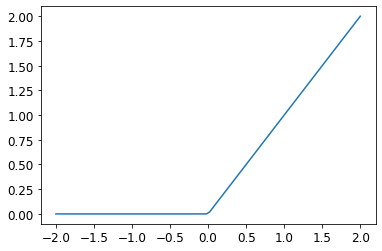

In [138]:
plot_function(F.relu)

In [139]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [140]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [141]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078720,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


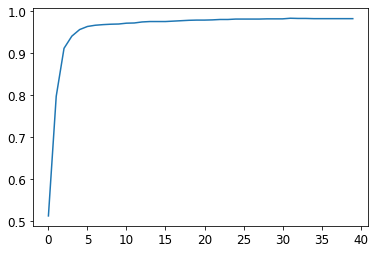

In [142]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [143]:
learn.recorder.values[-1][2]

0.98233562707901

- 이 시점에서 마법이라고 할만한 결과를 얻었다.
    - 올바른 파라미터 집합(w1, b1, w2, b2, ... )이 주어지면 모든 문제를 원하는 정확도로 풀어낼 수 있는 함수(신경망)
    - 모든 함수에 대한 최적의 파라미터 집합을 찾아내는 방법(SGD)
- 이 두 가지가 딥러닝이 환상적인 일을 해낼 수 있는 이유이다.

### Going Deeper
- 좀 더 깊은 모델

In [144]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.111870,0.017281,0.995093,00:23


## Jargon Recap
- 신경망은 수많은 수로 구성되지만, `계산된 수`와 `이 수를 계산하는 파라미터`라는 단 두 종류로 분류할 수 있다. 이는 가장 중요한 두 전문용어와 관련이 있다.
    - 활성(Activation): 선형 및 비선형 계층에서 계산된 수
    - 파라미터(Parameter): 임의로 초기화되고 최적화된 수(즉 모델을 정의하는 수)
- 활성과 파라미터는 추상적인 개념이 아니라 실제로 모델을 구성하는 구체적인 수이다. 뛰어난 딥러닝 실무자는 활성과 파라미터를 잘 살필줄 아는 사람이고, 그래프를 그려서 이들의 작동이 올바른지 검사 및 확인할 수 있어야 한다.
- 활성과 파라미터는 모두 `텐서`로 저장된다. 즉 행렬과 같은 일반적인 모양의 배열일 뿐이다. 행렬을 행과 열로 구성되는데, 이들을 `축` 또는 `차원`이라고 부르기도 한다. 텐서의 차원 개수는 해당 텐서의 랭크이다. 다음은 몇 가지 특별한 텐서의 예이다.
    - 랭크 0: 스칼라(단일 값)
    - 랭크 1: 벡터(1차원 배열 또는 시퀀스)
    - 랭크 2: 행렬
- `신경망`은 여러 계층으로 구성된다. 그리고 계층은 `선형` 또는 `비선형`의 형태를 따른다. 일반적으로 이 두 종류의 계층을 번갈아 사용하여 신경망을 만든다. 선형 계층과 따라 나오는 비선형 계층을 묶어서 하나의 계층이라고 표현하는 사람도 있다. 그래서 가끔은 혼란스러울지도 모른다. 때로는 비선형성을 `활성화 함수`라고 표현하기도 한다.(실제로 TensorFlow 프레임워크에서 계층을 선언할 때 각 계층에 매개변수로 활성화 함수를 지정할 수 있다.)
- SGD와 관련된 전문용어
    - ReLU: 양수의 입력은 그대로 출력하고 음수의 입력은 0으로 반환하는 함수
    - mini-batch(미니배치): 전체적인 데이터셋의 입력과 타겟 두 배열 안의 작은 그룹이다. 경사 하강 단계는 한 에포크 전체에 대해 수행되지 않고 미니배치 단위로 수행된다.
    - foward propagation(순전파): `입력을 모델에 적용하여 예측을 수행하는 과정`이다. 즉 입력과 파라미터의 조합을 아키텍쳐(모델)에 넣고 예측을 하기까지의 과정을 말한다.
    - loss(손실): 모델이 얼마나 잘하는지, 못하는지를 표현하는 값이다. 이를 토대로 SGD가 그래디언트를 계산(미분)한다.
    - gradient(그래디언트, 기울기, 경사도): 모델의 일부 파라미터에 대한 손실을 미분한 값이다. 이 값을 이용하여 모델이 예측을 더 잘할 수 있도록 파라미터를 조정한다.
    - backpropagation(역전파): 모델의 모든 파라미터에 대한 손실의 그래디언트를 계산하는 과정을 말한다.
    - gradient descent(경사 하강): 모델의 파라미터를 약간 더 좋게 만들려고 `그래디언트의 반대 방향`으로 나아가는 한 번의 단계를 말한다.
    - learning rate(학습률): SGD를 적용하여 모델의 파라미터가 갱신되어야 하는 크기를 말한다. 즉 경사 하강을 하는데, 어느 정도만큼을 하강해야하는지 나타내는 값이다.

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.